In [1]:
import numpy as np
import cv2
import queue, threading, time
from configparser import ConfigParser
from numpy.core.numeric import zeros_like
import matplotlib.pyplot as plt
import colorsys
import math
import random
from vidgear.gears import VideoGear
from vidgear.gears import WriteGear
import datetime
import os
import csv
import json
from mpl_toolkits.mplot3d import Axes3D

#hsv transform to rgb format
def hsv2rgb(h,s,v):
    return tuple(round(i * 255) for i in colorsys.hsv_to_rgb(h,s,v))

# 自定义卷积函数
def my_conv(input, kernel, step):
    output_size_0 = int((len(input) - len(kernel)) / step + 1)   # 输出结果的第0维长度
    output_size_1 = int((len(input[0]) - len(kernel[0])) / step + 1)   # 输出结果的第1维长度
    res = np.zeros([output_size_0, output_size_1], np.float32)

    for i in range(len(res)):
        for j in range(len(res[0])):
            a = input[i*step:i*step + len(kernel), j*step: j*step + len(kernel)]  # 从输入矩阵中取出子矩阵
            b = a * kernel  # 对应元素相乘
            res[i][j] = b.sum()   
    return res

# 自定义鼠标双击事件——获取图像坐标
# 1. 对图像进行操作，同时生成一副新的图像；
# maybe需要多线程
frame_cur = 0
horMat = 0
verMat = 0
mag = 0
# 自定义鼠标事件，获取该点的displacement
def on_EVENT_LBUTTONDOWN(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        xy = "%d,%d" % (x, y)
        mag_value       = mag[y, x]
        horMat_value    = horMat[y, x]
        verMat_value    = verMat[y, x]
        
        cv2.circle(frame_cur, (x-1, y-1), 2, (0, 0, 255), thickness = -1)
        if x < 650:
            cv2.putText(frame_cur, "x:{},y:{}".format(x,y), (x+10, y+10), cv2.FONT_HERSHEY_PLAIN,
                        1, (0,0,0), thickness = 2)
            cv2.putText(frame_cur, "dis is:{:.4f},{:.4f},{:.4f}".format(mag_value, horMat_value, verMat_value), (x+10, y+25), cv2.FONT_HERSHEY_PLAIN,
                        1, (0,0,0), thickness = 2)    
        else:
            cv2.putText(frame_cur, "x:{},y:{}".format(x,y), (x-100, y+10), cv2.FONT_HERSHEY_PLAIN,
                        1, (0,0,0), thickness = 2)    
            cv2.putText(frame_cur, "dis is:{:.4f},{:.4f},{:.4f}".format(mag_value, horMat_value, verMat_value), (x-260, y+25), cv2.FONT_HERSHEY_PLAIN,
                        1, (0,0,0), thickness = 2)    
        
        cv2.imshow("Orignal", frame_cur)
        if cv2.waitKey() & 0xFF ==27 :
            print("Continue Play!")
cv2.namedWindow('Orignal', cv2.WINDOW_NORMAL)
cv2.setMouseCallback("Orignal", on_EVENT_LBUTTONDOWN)

# 2. 对视频实施爬取，读取连续图像，并且可以生成曲线图；
# maybe需要多线程
# 还没想好
# 拆解成1. 固定点的位置抓取；2. 逐帧抓取数据
# 2. 逐帧抓取数据（可以用来对光流算法！！参数进行分析）


# 导出mag ang数据
def save_mag_ang(mag, ang, mag_copy):
    # 绘制magnitude图片
    # print("mag.shape: ", np.shape(mag))
    timeNow = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    save_path = "save_" + timeNow
    os.makedirs(save_path)
    np.savetxt(save_path + "/mag.txt", mag)
    np.savetxt(save_path + "/mag_copy.txt", mag_copy)
    np.savetxt(save_path + "/angle.txt", ang)
    return save_path
    
# 读取mag or ang数据
def read_mag_ang(txtPath):
    return np.loadtxt(txtPath)

# 分析背景噪声，使用直方图法分析所有点的矢量（包括对不同区域的分析）
kwargs = {
    "bins": 20,
    "histtype": "stepfilled",
    "alpha": 0.5
}

def myhist(durations, count, kwargs):
    plt.figure(figsize=(15,5))
    nums,bins,patches = plt.hist(durations, range=(0.1, 1.1), label=str(durations), **kwargs)
    # 保留有效数字
    bins = [round(x,3) for x in bins]
    plt.xticks(bins,bins)
    for num,bin in zip(nums,bins):
        plt.annotate(num,xy=(bin,num),xytext=(bin,num))        
    plt.xlabel('Displacements')
    plt.ylabel('Points')
    plt.title('%s times displacements distrubition' % count)
    plt.show()
    
# 去噪，并计算PDE的方法

# 显示多种结果
lay_2_2 = 0
lay_4_1 = 1
def initial_window(win_name, lay_flag):
    width   = 500
    height  = 400
    count = 0
    if lay_flag == lay_2_2:
        lay         = [(2,2),(0,1),(1,0),(1,1)]
        coff        = 1
    elif lay_flag == lay_4_1:
        lay         = [(0,0),(0,0.5),(0,1),(0,1.5)]
        coff        = 0.5
    # resizewindow 和resize 不一样，先resizewindow后 会根据图片的大小重新调整
    for name in win_name:
        act_width   = int(width * coff)
        act_height  = int(height * coff)
        loc_x       = int(lay[count][0]*width)
        loc_y       = int(lay[count][1]*height)
        cv2.namedWindow(name)
        cv2.resizeWindow(name, act_width, act_height)
        cv2.moveWindow(name, loc_x, loc_y)
        count += 1 
        
def initial_particle_pic():
    pic_initial = cv2.imread('./pic_particle/v2-76164ddfce5ca8f73532725d9dde78c8_r.jpg')
    cv2.imshow('particle picture', pic_initial)

In [39]:
# 当前使用[800, 600]分辨率显示视频；相机视频流还待开发；需要编写接口使其适配各种分辨率；
# 开发分析mag的接口；                                                                           已完成
# 讲几个窗口分别按位置放置；or 一边显示图案，另一边显示结果                                         cv2.movewindow      不太行，resize和resizewindow的冲突
# 图形化分析：
# 1. 鼠标事件，用矩形框抓取区域内的矢量参数； 
# 2. 鼠标事件，固定鼠标位置，逐帧抓取该点矢量参数，并绘制曲线图； 
# 3. 鼠标事件，固定矩形框区域，逐帧抓取该区域矢量参数，并绘制曲线图；

In [ ]:
# -*- coding: utf-8 -*-
"""
功能：识别两块显示器各自的分辨率
"""
"""模块导入"""
from win32api import GetSystemMetrics
from win32con import SM_CMONITORS, SM_CXVIRTUALSCREEN, SM_CYVIRTUALSCREEN

#显示器数量检测
MonitorNumber = GetSystemMetrics(SM_CMONITORS)
#主屏幕尺寸检测
MajorScreenWidth=GetSystemMetrics(0)#主屏幕宽
MajorScreenHeight=GetSystemMetrics(1)#主屏幕高
print("主屏幕尺寸：", GetSystemMetrics(0),"*", GetSystemMetrics(1))
# 屏幕最大尺寸
aScreenWidth = GetSystemMetrics(SM_CXVIRTUALSCREEN)  # 屏幕最大宽度
aScreenHeight = GetSystemMetrics(SM_CYVIRTUALSCREEN)  # 屏幕最大高度
print("屏幕总尺寸:",aScreenWidth,"*",aScreenHeight)
#当前主流的分辨率基数是宽，偶数是高
ResolvingPower=[1280,720,1920,1080,2560,1440,3840,2160,4096,2160,7680,4320]

if MonitorNumber > 1:#屏幕数量判断print(MonitorNumber)就可以知道有多少块屏幕
    SecondaryScreenWidth=aScreenWidth-MajorScreenWidth#副屏宽=总屏幕宽-当前屏幕宽

In [40]:
#control parameters
is_save_stream = False
is_anti_shake = False
is_ref_refresh = is_anti_shake
is_change_size = True
is_hist_show = False
is_mag = 1
is_ang = 0
select_ang_or_mag = is_mag # 0 is ang, 1 is mag
windows_name = ['Orignal','Palette','Blender','Area of Intrest Blended']

# default parameters  
# calculation parameters
winsize = 64
mag_ceiling = 0.5
mag_floor = mag_ceiling/5

# camer & image parameters
alpha = 0.8 
hue = 90                     
RES=(1920,1080)                 # camera resolution
# roi_rect = [0,RES[0],0,RES[1]]  # region of interesting
roi_rect = [200,600,115,420] # 转置前

result_RES = (1080, 720)         # flow image resolution
# options = {"CAP_PROP_FRAME_WIDTH":2592, "CAP_PROP_FRAME_HEIGHT":1944, "CAP_PROP_FPS":30}
options = {"CAP_PROP_FRAME_WIDTH":800, "CAP_PROP_FRAME_HEIGHT":600, "CAP_PROP_FPS":30}
# stable calculation parameters
pyr_scale = 0.5
levels = 2
iterations = 1
poly_n = 5
poly_sigma = 1.1
flags = cv2.OPTFLOW_FARNEBACK_GAUSSIAN
Noffset = 30 # 消除光流算法偏差的位移量
# drawing buffer
ax = []
ay1 = []
ay2 = [] 
#plt.ion()

In [41]:
# 水平噪声、数值噪声
# stream = VideoGear(source="./WIN_20230329_16_13_08_Pro.mp4", stabilize= is_anti_shake , resolution=RES, **options).start()
stream = VideoGear(source="./WIN_20230329_16_13_08_Pro.mp4", stabilize= is_anti_shake , resolution=RES, **options).start()

# pre-read frame
frame_pre = stream.read()
print("video resolution is (height, width, channel) : ",frame_pre.shape)
bgr_pre = cv2.cvtColor(frame_pre, cv2.COLOR_BGR2GRAY)
# initial hsv
hsv = np.zeros_like(frame_pre)  
# hsv = np.zeros_like(frame_pre[roi_rect[2]:roi_rect[3],roi_rect[0]:roi_rect[1]])  
hsv[...,1] = 255 #saturation is full
blank = np.zeros_like(frame_pre)

# video loop
count = 0
print("begin stream!")

# # begin window
initial_window(windows_name, lay_2_2)
initial_particle_pic()

while True:
    try:
        frame_cur = stream.read()
        if frame_cur is None:
            print("video has played over!")
            break
        count += 1
        if count < 60:
            print("%d times"% count)
            continue
        bgr_cur = cv2.cvtColor(frame_cur, cv2.COLOR_BGR2GRAY) # change in to gray
        # 测量两幅同样图像
        if is_ref_refresh:
            bgr_pre = bgr_cur
        
        if is_change_size:
            # 改变图像大小
            # resize_resolution = [1296, 972]    
            resize_resolution   = [800, 600]
            frame_pre           = cv2.resize(frame_pre ,resize_resolution)
            frame_cur           = cv2.resize(frame_cur ,resize_resolution)
            bgr_pre             = cv2.resize(bgr_pre ,resize_resolution)
            bgr_cur             = cv2.resize(bgr_cur ,resize_resolution)
            hsv                 = cv2.resize(hsv ,resize_resolution)
            blank               = cv2.resize(blank ,resize_resolution)
        
        # 图像裁切
        roi_bgr_pre = bgr_pre
        roi_bgr_cur = bgr_cur
        
        flow = cv2.calcOpticalFlowFarneback(roi_bgr_pre,roi_bgr_cur, None,
                                        pyr_scale,
                                        levels,
                                        winsize,
                                        iterations,
                                        poly_n,
                                        poly_sigma,
                                        flags)
        mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])  # orginal flow
        
        
        # 绘制矢量箭头方案一：opencv-arrowedline
        min_arrowline_threshold = 1.5   # 矢量箭头阈值下限（与矢量平均值相除）
        max_arrowline_threshold = 10    # 矢量箭头阈值下限
        step = 20                       # 卷积模板步长
        half_step = int(step/2)         # 卷积模板的半步长
        # 1. 确定要画的mag及其坐标
        mag_mean = cv2.mean(mag)[0]
        mag_copy = mag
        mag_copy = np.where(mag_copy > min_arrowline_threshold * mag_mean, mag_copy, 0)
        mag_copy = np.where(mag_copy < max_arrowline_threshold * mag_mean, mag_copy, 0)
        kernel = np.ones((half_step, half_step)) / half_step**2
        mag_conv = my_conv(mag_copy, kernel, step)
        ang_conv = my_conv(ang, kernel, step)
        
        horMat = np.multiply(mag_conv, np.cos(ang_conv))
        verMat = np.multiply(mag_conv, np.sin(ang_conv))
        # 2. 卷积形成矢量箭头
        for index, value in np.ndenumerate(mag_conv):
            if value != 0.0:
                # print(index, value, horMat[index], verMat[index])
                cv2.arrowedLine(frame_cur, (index[1]*step, index[0]*step) ,(index[1]*step+int(horMat[index]*step), index[0]*step+int(verMat[index]*step)), (255, 0, 0), 2, 9, 0, 0.3)  # 画箭头
        
        # 加入直方图统计
        if is_hist_show:
            mag_1d = mag.flatten()
            mag_1d = mag_1d.tolist()
            myhist(mag_1d, count, kwargs)
        
        # mag的后处理
        mag_sft = abs(mag - mag_mean)  # shifted magnitude to elimiate noise
        
        if select_ang_or_mag == is_ang:
            # ang决定色彩
            hsv[...,0] = (ang + hue)*180/np.pi/2 # color space related to angle 
            hsv[...,2] = cv2.normalize(mag_sft,None,0,255,cv2.NORM_MINMAX) 
            bgr_flow = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)
        else:
            # mag决定色彩
            mag_int = (np.pi*2/np.max(mag)*mag).astype(np.int16)
            hsv[...,0] = (mag_int + hue)*180/np.pi/2 # color space related to angle  # 分子分布在[0, 2pi]
            hsv[...,2] = cv2.normalize(mag_sft,None,0,255,cv2.NORM_MINMAX) 
            bgr_flow = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)
        
        
        #enhanced flow
        mag_enhanced = zeros_like(mag_sft)
        cv2.min(mag_sft,mag_ceiling,mag_enhanced)  # enhance flow, ceiling and flooring
        cv2.max(mag_enhanced,mag_floor,mag_enhanced)
        hsv[...,0] = (ang + hue)*180/np.pi/2 # color space related to angle 
        hsv[...,2] = cv2.normalize(mag_enhanced,None,0,255,cv2.NORM_MINMAX)
        bgr_flow_enhanced = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)

        # image emerge with enhanced flow
        flow_blend_enhance = cv2.addWeighted(frame_cur, 1-alpha ,bgr_flow_enhanced,  alpha, 0)
        bgr_blend = cv2.addWeighted(frame_cur, 1-alpha ,bgr_flow,  alpha, 0)
        frame_blend = flow_blend_enhance
        
        if is_ref_refresh:
            bgr_pre = bgr_cur
        
        #palette
        palette=np.zeros((512,512,3),np.uint8)
        mag_norm = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
        mag_min,mag_max,min_indx,max_indx=cv2.minMaxLoc(mag)
        ang_mean = cv2.mean(ang*mag/mag_mean)[0]

        # 对结果矩阵偏移的修正
        horMat = np.multiply(mag, np.cos(ang))
        verMat = np.multiply(mag, np.sin(ang))

        # 计算水平噪声最大值和竖直噪声最大值
        _,hor_MaxNoise, _, _ = cv2.minMaxLoc(np.multiply(mag, np.cos(ang)))
        _,ver_MaxNoise, _, _ = cv2.minMaxLoc(np.multiply(mag, np.sin(ang)))


        # 计算水平噪声和竖直噪声
        hor_Noise = np.average(np.multiply(mag, np.cos(ang)))
        ver_Noise = np.average(np.multiply(mag, np.sin(ang)))
        # # 绝对值计算水平噪声和竖直噪声
        # hor_AbsNoise = np.average(np.abs(horMat))
        # ver_AbsNoise = np.average(np.abs(verMat))

 
    except Exception:
        # read current frame from cap
        print("something wrong!")
        stream.stop()  
        raise
    
    else:
        # # result flow image
        print("nothing wrong!")
        print("%d times"% count)
        # palette show
        cv2.putText(palette, "max="+str(mag.max()), (0, 30), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255, 255, 255), 2)
        cv2.putText(palette, "mag_mean="+str("%.7f"%mag_mean), (0, 60), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255, 255, 255), 2)
        cv2.putText(palette, "mag_max="+str(mag_max), (0, 90), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255, 255, 255), 2)
        cv2.putText(palette, "mag_min="+str(mag_min), (0, 120), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255, 255, 255), 2)
        cv2.putText(palette, "hor_Noise="+str(hor_Noise), (0, 150), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255, 255, 255), 2)
        cv2.putText(palette, "ver_Noise="+str(ver_Noise), (0, 180), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255, 255, 255), 2)
        cv2.putText(palette, "hor_MaxNoise="+str(hor_MaxNoise), (0, 210), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255, 255, 255), 2)
        cv2.putText(palette, "ver_MaxNoise="+str(ver_MaxNoise), (0, 240), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255, 255, 255), 2)
        # original show
        # cv2.imshow('Orignal',cv2.resize(frame_cur, (result_RES[0], result_RES[1]))) # resize函数的显示窗口会对鼠标事件产生干扰！
        cv2.putText(frame_cur, "Frame is:{} ".format(count), (10, 35), cv2.FONT_HERSHEY_PLAIN,
                        3.0, (0,0,0), thickness = 3) 

        cv2.imshow('Orignal', frame_cur)
        cv2.imshow("Palette", palette)
        # cv2.imshow('Blender', cv2.resize(bgr_blend , (result_RES[0], result_RES[1])))
        # cv2.imshow('Area of Intrest Blended', cv2.resize(frame_blend  , (result_RES[0], result_RES[1])))
        cv2.imshow('Blender', bgr_blend)
        cv2.imshow('Area of Intrest Blended', frame_blend)
        
        # keyboard event
        # key 'r'   : refresh img
        # key 'q'   : quit
        # key 'ESC' : quit mouse event
        # key 's'   : save data
        key = cv2.waitKey(1)
        if key == ord("r"):
            bgr_pre = bgr_cur
            print("Background Refresh!")
        if key == ord("q"):
            print("KeyboardInterrupt!")
            break
        if key == ord("s"):
            # 结果矩阵为mag，调用到鼠标事件中
            save_path = save_mag_ang(mag, ang, mag_copy)
            cv2.imwrite(save_path+"/Original.jpg", frame_cur)
            cv2.imwrite(save_path+"/Blender.jpg", bgr_blend)
            print("save data!")
        

cv2.destroyAllWindows()
stream.stop()  

video resolution is (height, width, channel) :  (1944, 2592, 3)
begin stream!
1 times
2 times
3 times
4 times
5 times
6 times
7 times
8 times
9 times
10 times
11 times
12 times
13 times
14 times
15 times
16 times
17 times
18 times
19 times
20 times
21 times
22 times
23 times
24 times
25 times
26 times
27 times
28 times
29 times
30 times
31 times
32 times
33 times
34 times
35 times
36 times
37 times
38 times
39 times
40 times
41 times
42 times
43 times
44 times
45 times
46 times
47 times
48 times
49 times
50 times
51 times
52 times
53 times
54 times
55 times
56 times
57 times
58 times
59 times
nothing wrong!
60 times
nothing wrong!
61 times
nothing wrong!
62 times
nothing wrong!
63 times
nothing wrong!
64 times
nothing wrong!
65 times
nothing wrong!
66 times
nothing wrong!
67 times
nothing wrong!
68 times
nothing wrong!
69 times
nothing wrong!
70 times
nothing wrong!
71 times
nothing wrong!
72 times
nothing wrong!
73 times
nothing wrong!
74 times
nothing wrong!
75 times
nothing wrong!
7

In [ ]:
x = np.arange(9.).reshape(3, 3)
np.where(x < 5, x, 0)




In [ ]:
import numpy as np 
import cv2
import matplotlib.pyplot as plt

# 水平噪声、数值噪声
stream = VideoGear(source="./WIN_20230329_16_13_08_Pro.mp4", stabilize= is_anti_shake , resolution=RES, **options).start()

# pre-read frame
frame_pre = stream.read()
print("video resolution is (height, width, channel) : ",frame_pre.shape)
bgr_pre = cv2.cvtColor(frame_pre, cv2.COLOR_BGR2GRAY)
# initial hsv
hsv = np.zeros_like(frame_pre)  
# hsv = np.zeros_like(frame_pre[roi_rect[2]:roi_rect[3],roi_rect[0]:roi_rect[1]])  
hsv[...,1] = 255 #saturation is full
blank = np.zeros_like(frame_pre)

# video loop
count = 0
print("begin stream!")


cv2.arrowedLine(frame_pre,(100,100), (80,80), color = (0, 255, 0), thickness=2, line_type=0, shift=0, tipLength=0.2)
cv2.imshow("test", cv2.resize(frame_pre, [800, 600]))
cv2.waitKey()
cv2.destroyAllWindows()


In [ ]:
import numpy as np

x = np.arange(1, 21).reshape(5, 4)
w = np.ones((2, 2)) /4



z = my_conv(x, w, 1)
print(x)
print(z)

In [ ]:
import cv2
from pylab import *
from PIL import Image
import sys
import copy
input_img = "./WIN_20230329_16_13_08_Pro.mp4"
#例如E:\demo\1.jpg

def rgb2hex(rgb_list):
    #rgb_list = bgr_list[::-1]
    #print(rgb_list)
    res = "#"
    for a in rgb_list:
        a_hex = hex(a)
        if a<16:
            res+="0"
            res+= a_hex[2:]
        else:
            res+= a_hex[2:]
    return res
            
        
def video_flag():
    frame = 0
    cap = cv2.VideoCapture(input_img)
    fps = cap.get(cv2.CAP_PROP_FPS)
    print("fps: ", fps)
    # frame=cv2.imread('E:/temp/vlcsnap-2020-09-11-17h35m32s537.png')

    def on_EVENT_LBUTTONDOWN(event, x, y, flags, param):
        if event == cv2.EVENT_LBUTTONDOWN:
            xy = "%d,%d" % (x, y)
            cv2.circle(frame, (x-1, y-1), 1, (255, 0, 0), thickness = -1)
            cv2.putText(frame, xy, (x+10, y+10), cv2.FONT_HERSHEY_PLAIN,
                        3.0, (0,0,0), thickness = 3)
            print("x:{},y:{}".format(x,y))
            bgr_list = frame[y, x]
            rgb_list = bgr_list[::-1]
            print("RGB为: ", rgb_list)
            print("十六进制颜色：", rgb2hex(rgb_list))
            print("--"*20)
            cv2.imshow("video", frame)
    cv2.namedWindow('video', cv2.WINDOW_NORMAL)
    cv2.setMouseCallback("video", on_EVENT_LBUTTONDOWN)

    while(True):
        ret, frame = cap.read()
        if ret is False:
            print("video play over!")
            break
        cv2.imshow("video", frame)
        if cv2.waitKey(2000) & 0xFF == 27:
            break
    cap.release()
    cv2.destroyAllWindows()

video_flag()




In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use("ggplot")
durations = [131,  98, 125, 131, 124, 139, 131, 117, 128, 108, 135, 138, 131, 102, 107, 114, 119, 128, 121, 142, 127, 130, 124, 101, 110, 116, 117, 110, 128, 128, 115,  99, 136, 126, 134,  95, 138, 117, 111,78, 132, 124, 113, 150, 110, 117,  86,  95, 144, 105, 126, 130,126, 130, 126, 116, 123, 106, 112, 138, 123,  86, 101,  99, 136,123, 117, 119, 105, 137, 123, 128, 125, 104, 109, 134, 125, 127,105, 120, 107, 129, 116, 108, 132, 103, 136, 118, 102, 120, 114,105, 115, 132, 145, 119, 121, 112, 139, 125, 138, 109, 132, 134,156, 106, 117, 127, 144, 139, 139, 119, 140,  83, 110, 102,123,107, 143, 115, 136, 118, 139, 123, 112, 118, 125, 109, 119, 133,112, 114, 122, 109, 106, 123, 116, 131, 127, 115, 118, 112, 135,115, 146, 137, 116, 103, 144,  83, 123, 111, 110, 111, 100, 154,136, 100, 118, 119, 133, 134, 106, 129, 126, 110, 111, 109, 141,120, 117, 106, 149, 122, 122, 110, 118, 127, 121, 114, 125, 126,114, 140, 103, 130, 141, 117, 106, 114, 121, 114, 133, 137,  92,121, 112, 146,  97, 137, 105,  98, 117, 112,  81,  97, 139, 113,134, 106, 144, 110, 137, 137, 111, 104, 117, 100, 111, 101, 110,105, 129, 137, 112, 120, 113, 133, 112,  83,  94, 146, 133, 101,131, 116, 111,  84, 137, 115, 122, 106, 144, 109, 123, 116, 111,111, 133, 150]
plt.figure(figsize=(15,5))
nums,bins,patches = plt.hist(durations,bins=20,edgecolor='k',cumulative=False)
plt.xticks(bins,bins)
for num,bin in zip(nums,bins):
    plt.annotate(num,xy=(bin,num),xytext=(bin+1.5,num+0.5))
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


np.random.seed(123)

x1 = np.random.normal(0, 1, size=1000)
x2 = np.random.normal(-2, 3, size=1000)
x3 = np.random.normal(3, 2.5, size=1000)
X = [x1, x2, x3]


kwargs = {
    "bins": 20,
    "histtype": "stepfilled",
    "alpha": 0.5
}

def myhist(durations, kwargs):
    plt.figure(figsize=(15,5))
    nums,bins,patches = plt.hist(durations, label=str(durations), **kwargs)
    # 保留有效数字
    bins = [round(x,2) for x in bins]
    plt.xticks(bins,bins)
    for num,bin in zip(nums,bins):
        plt.annotate(num,xy=(bin,num),xytext=(bin,num))
    plt.show()
    
myhist(x2,kwargs)
    

In [1]:
# 拖拽获取框型区域

import cv2
global img
global point1,point2

def on_mouse(event,x,y,flags,param):
    global img,point1,point2
    img2=img.copy()
    if event==cv2.EVENT_LBUTTONDOWN:#左键点击
        point1=(x,y)
        cv2.circle(img2,point1,10,(0,255,0),5)
        cv2.imshow('image',img2)

    elif event==cv2.EVENT_MOUSEMOVE and (flags&cv2.EVENT_FLAG_LBUTTON):#移动鼠标，左键拖拽
        cv2.rectangle(img2,point1,(x,y),(255,0,0),15)#需要确定的就是矩形的两个点（左上角与右下角），颜色红色，线的类型（不设置就默认）。
        cv2.imshow('image',img2)

    elif event==cv2.EVENT_LBUTTONUP:#左键释放
        point2=(x,y)
        cv2.rectangle(img2,point1,point2,(0,0,255),5)#需要确定的就是矩形的两个点（左上角与右下角），颜色蓝色，线的类型（不设置就默认）。
        cv2.imshow('image',img2)
        min_x=min(point1[0],point2[0])
        min_y=min(point1[1],point2[1])
        width=abs(point1[0]-point2[0])
        height=abs(point1[1]-point2[1])
        cut_img=img[min_y:min_y+height,min_x:min_x+width]


def main():
    global img
    img=cv2.imread(r'pic_particle\20200808142627977.png')
    cv2.namedWindow('image')
    cv2.setMouseCallback('image',on_mouse)
    cv2.imshow('image',img)
    cv2.waitKey(0)


if __name__=='__main__':
    main()





In [12]:
import numpy as np
import cv2
import queue, threading, time
from configparser import ConfigParser
from numpy.core.numeric import zeros_like
import matplotlib.pyplot as plt
import colorsys
import math
import random
from vidgear.gears import VideoGear
from vidgear.gears import WriteGear
import datetime
import os
import csv
import json
from mpl_toolkits.mplot3d import Axes3D
# 导出mag ang数据
def save_mag_ang(mag, ang, mag_copy):
    # 绘制magnitude图片
    # print("mag.shape: ", np.shape(mag))
    timeNow = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    save_path = "save_" + timeNow
    os.makedirs(save_path)
    np.savetxt(save_path + "/mag.txt", mag)
    np.savetxt(save_path + "/mag_copy.txt", mag_copy)
    np.savetxt(save_path + "/angle.txt", ang)
    return save_path
    
# 读取mag or ang数据
def read_mag_ang(txtPath):
    return np.loadtxt(txtPath)

mag = read_mag_ang('save_20230408_131003/mag.txt')
mag_copy = read_mag_ang('save_20230408_131003/mag_copy.txt')
ang = read_mag_ang('save_20230408_131003/angle.txt')
print(mag.shape)

# 对结果矩阵偏移的修正
horMat = np.multiply(mag, np.cos(ang))
verMat = np.multiply(mag, np.sin(ang))

(600, 800)


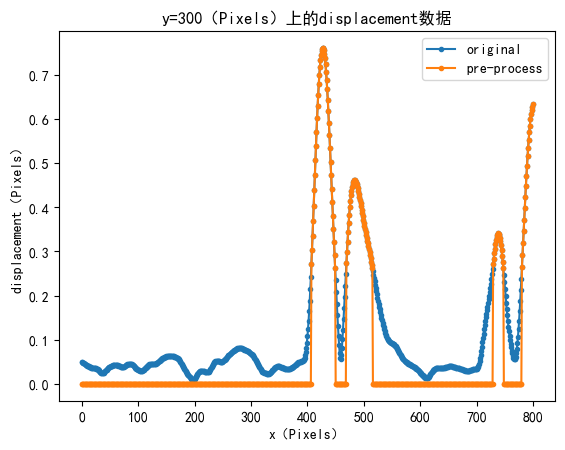

In [13]:


import matplotlib.pyplot as plt
import numpy as np

x_axis_data = list(range(0, 800))
y1_axis_data = list(mag[300])
y2_axis_data = list(mag_copy[300])
y3_axis_data = list(horMat[300])
y4_axis_data = list(verMat[300])


# plt.plot(x_axis_data, y1_axis_data, 'b', alpha=0.5, linewidth=1, label='dis')#'bo-'表示蓝色实线，数据点实心原点标注
## plot中参数的含义分别是横轴值，纵轴值，线的形状（'s'方块,'o'实心圆点，'*'五角星   ...，颜色，透明度,线的宽度和标签 ，
plt.title('y=300（Pixels）上的displacement数据')  # 折线图标题
plt.rcParams['font.sans-serif'] = ['SimHei']  # 显示汉字
plt.xlabel('x（Pixels）')  # x轴标题
plt.ylabel('displacement（Pixels）')  # y轴标题
plt.plot(x_axis_data, y1_axis_data, marker='o', markersize=3)  # 绘制折线图，添加数据点，设置点的大小
plt.plot(x_axis_data, y2_axis_data, marker='o', markersize=3)

#for a, b in zip(x_axis_data, y1_axis_data):
#    plt.text(a, b, b, ha='center', va='bottom', fontsize=10)  # 设置数据标签位置及大小
#for a, b in zip(x, y2):
#    plt.text(a, b, b, ha='center', va='bottom', fontsize=10)

plt.legend(['original', 'pre-process'])  # 设置折线名称

plt.show()  # 显示折线图


C:\Users\18120\AppData\Roaming\Python\Python38\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


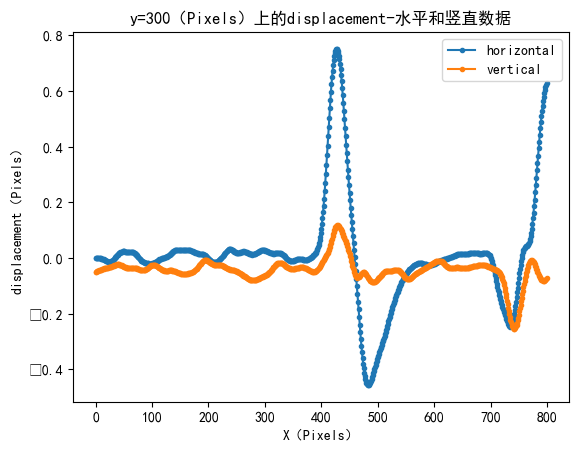

: 

In [14]:
plt.title('y=300（Pixels）上的displacement-水平和竖直数据')  # 折线图标题
plt.rcParams['font.sans-serif'] = ['SimHei']  # 显示汉字
plt.xlabel('X（Pixels）')  # x轴标题
plt.ylabel('displacement（Pixels）')  # y轴标题
plt.plot(x_axis_data, y3_axis_data, marker='o', markersize=3)  # 绘制折线图，添加数据点，设置点的大小
plt.plot(x_axis_data, y4_axis_data, marker='o', markersize=3)

#for a, b in zip(x_axis_data, y1_axis_data):
#    plt.text(a, b, b, ha='center', va='bottom', fontsize=10)  # 设置数据标签位置及大小
#for a, b in zip(x, y2):
#    plt.text(a, b, b, ha='center', va='bottom', fontsize=10)

plt.legend(['horizontal', 'vertical'])  # 设置折线名称

plt.show()  # 显示折线图

In [16]:
list(mag[300])

[0.0027096413541585207,
 0.0016964114038273692,
 0.0011470274766907096,
 0.001389469369314611,
 0.0020308098755776882,
 0.0027019125409424305,
 0.0032943375408649445,
 0.0038049088325351477,
 0.004247052129358053,
 0.00465397397056222,
 0.005053027532994747,
 0.005486638750880957,
 0.00601445697247982,
 0.006674544885754585,
 0.007486897055059671,
 0.008454888127744198,
 0.009559028781950474,
 0.0107674365863204,
 0.012047572061419487,
 0.01336145494133234,
 0.014672239311039448,
 0.01594305783510208,
 0.01713886298239231,
 0.018237067386507988,
 0.01921440288424492,
 0.020040662959218025,
 0.020705530419945717,
 0.021208520978689194,
 0.0215478353202343,
 0.021722309291362762,
 0.021739574149250984,
 0.02161743864417076,
 0.021379947662353516,
 0.021052880212664604,
 0.020676614716649055,
 0.020310556516051292,
 0.020018497481942177,
 0.01986253447830677,
 0.0198921337723732,
 0.020147128030657768,
 0.020646655932068825,
 0.021373014897108078,
 0.022292697802186012,
 0.023340895771980

In [2]:
# -*- coding: utf-8 -*-
"""
功能：识别两块显示器各自的分辨率
"""
"""模块导入"""
from win32api import GetSystemMetrics
from win32con import SM_CMONITORS, SM_CXVIRTUALSCREEN, SM_CYVIRTUALSCREEN

#显示器数量检测
MonitorNumber = GetSystemMetrics(SM_CMONITORS)
#主屏幕尺寸检测
MajorScreenWidth=GetSystemMetrics(0)#主屏幕宽
MajorScreenHeight=GetSystemMetrics(1)#主屏幕高
print("主屏幕尺寸：", GetSystemMetrics(0),"*", GetSystemMetrics(1))
# 屏幕最大尺寸
aScreenWidth = GetSystemMetrics(SM_CXVIRTUALSCREEN)  # 屏幕最大宽度
aScreenHeight = GetSystemMetrics(SM_CYVIRTUALSCREEN)  # 屏幕最大高度
print("屏幕总尺寸:",aScreenWidth,"*",aScreenHeight)
#当前主流的分辨率基数是宽，偶数是高
ResolvingPower=[1280,720,1920,1080,2560,1440,3840,2160,4096,2160,7680,4320]

if MonitorNumber > 1:#屏幕数量判断print(MonitorNumber)就可以知道有多少块屏幕
    SecondaryScreenWidth=aScreenWidth-MajorScreenWidth#副屏宽=总屏幕宽-当前屏幕宽
    # print("副屏宽",SecondaryScreenWidth)

    #主屏横竖屏检测
    if GetSystemMetrics(0)>GetSystemMetrics(1):
        print("主屏幕是横屏")
    else:
        print("主屏幕是竖屏")

    #横屏状态
    for i in range(0, len(ResolvingPower) - 1,2):
        # print("i",ResolvingPower[i])
        if SecondaryScreenWidth == ResolvingPower[i]:
            print("副屏(横屏)尺寸：", ResolvingPower[i], ResolvingPower[i + 1])
            break
    #竖屏状态
    for i in range(1, len(ResolvingPower) - 1,2):
        # print("i",ResolvingPower[i])
        if SecondaryScreenWidth == ResolvingPower[i]:
            print("副屏(竖屏)尺寸：", ResolvingPower[i], ResolvingPower[i - 1])
            break



主屏幕尺寸： 2560 * 1440
屏幕总尺寸: 2560 * 1440
